## Imports

In [1]:
# Import packages
import pandas as pd
import numpy as np
import scipy.stats as stats
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

import gff2bed
import Orthoscripts

# Disable chained assignments
pd.options.mode.chained_assignment = None 

#### Import genelists

In [3]:
# Asterias rubens
Astrub = Orthoscripts.readBED("Data/Genelists/Asterias.rubens.genelist.bed")

# Holothuria leucospilota
Holleu = Orthoscripts.readBED("Data/Genelists/Holothuria.leucospilota.genelist.bed")

# Paracentrotus livides
Parliv = Orthoscripts.readBED("Data/Genelists/Paracentrotus.lividus.genelist.bed")

# Branchiostoma lanceolatum
Bralan = Orthoscripts.readBED("Data/Genelists/Branchiostoma.lanceolatum.genelist.bed")

# Branchiostoma floridae
Braflo = Orthoscripts.readBED("Data/Genelists/Branchiostoma.floridae.genelist.bed")

# Marthasterias glacialis
Margla = Orthoscripts.readBED("Data/Genelists/Marthasterias.glacialis.genelist.bed")

# Pecten maximus
Pecmax = Orthoscripts.readBED("Data/Genelists/Pecmax.genelist.bed")

# Stichopus chloronotus
Stichl = Orthoscripts.readBED("Data/Genelists/Stichopus.chloronotus.genelist.bed")

# Amphiura filiformis 
Ampfil = Orthoscripts.readBED("Data/Genelists/Amphiura.filiformis.genelist.bed")

# Ancestor 
Ancestor = Orthoscripts.readBED("Data/Genelists/Ancestor.genelist.bed")

#### Import ortholog files

In [4]:
# Import orthologs
Astrub_Holleu = np.loadtxt("Data/Orthologs/Asterias.rubens+Holothuria.leucospilota.txt", dtype = "str")

Astrub_Parliv = np.loadtxt("Data/Orthologs/Asterias.rubens+Paracentrotus.lividus.txt", dtype = "str")

Holleu_Parliv = np.loadtxt("Data/Orthologs/Holothuria.leucospilota+Paracentrotus.lividus.txt", dtype = "str")

Margla_Bralan = np.loadtxt("Data/Orthologs/Marthasterias.glacialis+Branchiostoma.lanceolatum.txt", dtype = "str")

Margla_Pecmax = np.loadtxt("Data/Orthologs/Marthasterias.glacialis+Pecten.maximus.txt", dtype = "str")

Margla_Stichl = np.loadtxt("Data/Orthologs/Marthasterias.glacialis+Stichopus.chloronotus.txt", dtype = "str")

Pecmax_Bralan = np.loadtxt("Data/Orthologs/Pecten.maximus+Branchiostoma.lanceolatum.txt", dtype = "str")

Stichl_Bralan = np.loadtxt("Data/Orthologs/Stichopus.chloronotus+Branchiostoma.lanceolatum.txt", dtype = "str")

Stichl_Pecmax = np.loadtxt("Data/Orthologs/Stichopus.chloronotus+Pecten.maximus.txt", dtype = "str")

Pecmax_Holleu = np.loadtxt("Orthology pipeline/orthologs/Pecmax+Holleu_sensitive.txt", dtype = "str")

Holleu_Bralan = np.loadtxt("Orthology pipeline/orthologs/Holleu+Bralan_sensitive.txt", dtype = "str")

Pecmax_Bralan = np.loadtxt("Orthology pipeline/orthologs/Pecmax+Bralan_sensitive.txt", dtype = "str")

Pecmax_Braflo = np.loadtxt("Orthology pipeline/orthologs/Pecmax+Braflo_sensitive.txt", dtype = "str")

Holleu_Braflo = np.loadtxt("Orthology pipeline/orthologs/Holleu+Braflo_sensitive.txt", dtype = "str")

Holleu_Ampfil = np.loadtxt("Data/Orthologs/Holothuria.leucospilota+Amphiura.filiformis.txt", dtype = "str")

#### Sorting out the data

In [5]:
Astrub = Astrub.loc[Astrub['Chromosome'].str.contains('chr')]
Bralan = Bralan.loc[Bralan['Chromosome'].str.contains('BFL_')]
Braflo = Braflo.loc[Braflo['Chromosome'].str.contains('BFL_')]
Pecmax = Pecmax.loc[Pecmax['Chromosome'].str.contains('PYE_')]

# Parliv genelist: select chromosomal scaffolds
Parliv = Orthoscripts.unscaff(Parliv, 100)
Ampfil = Orthoscripts.unscaff(Ampfil, 100)

Astrub_Parliv = Orthoscripts.orthFix(Astrub_Parliv, 'B', 'Parliv_', 1)
Margla_Bralan = Orthoscripts.orthFix(Margla_Bralan, 'A', '.1', 0)
Margla_Stichl = Orthoscripts.orthFix(Margla_Stichl, 'A', '.1', 0)
Margla_Stichl = Orthoscripts.orthFix(Margla_Stichl, 'B', '.1', 0)
Margla_Pecmax = Orthoscripts.orthFix(Margla_Pecmax, 'B', '.1', 0)
Holleu_Ampfil = Orthoscripts.orthFix(Holleu_Ampfil, 'B', '.1', 0)
Holleu_Bralan = Orthoscripts.orthFix(Holleu_Bralan, 'B', '_', 0)

##    
------

### GFF

In [21]:
bed_data = pd.DataFrame(Orthoscripts.convert((Orthoscripts.readGFF('Data/GCA_002113885.2.gff')))) 
bed_data.head()

KeyError: 'protein_id'

##  
-----

## Plots

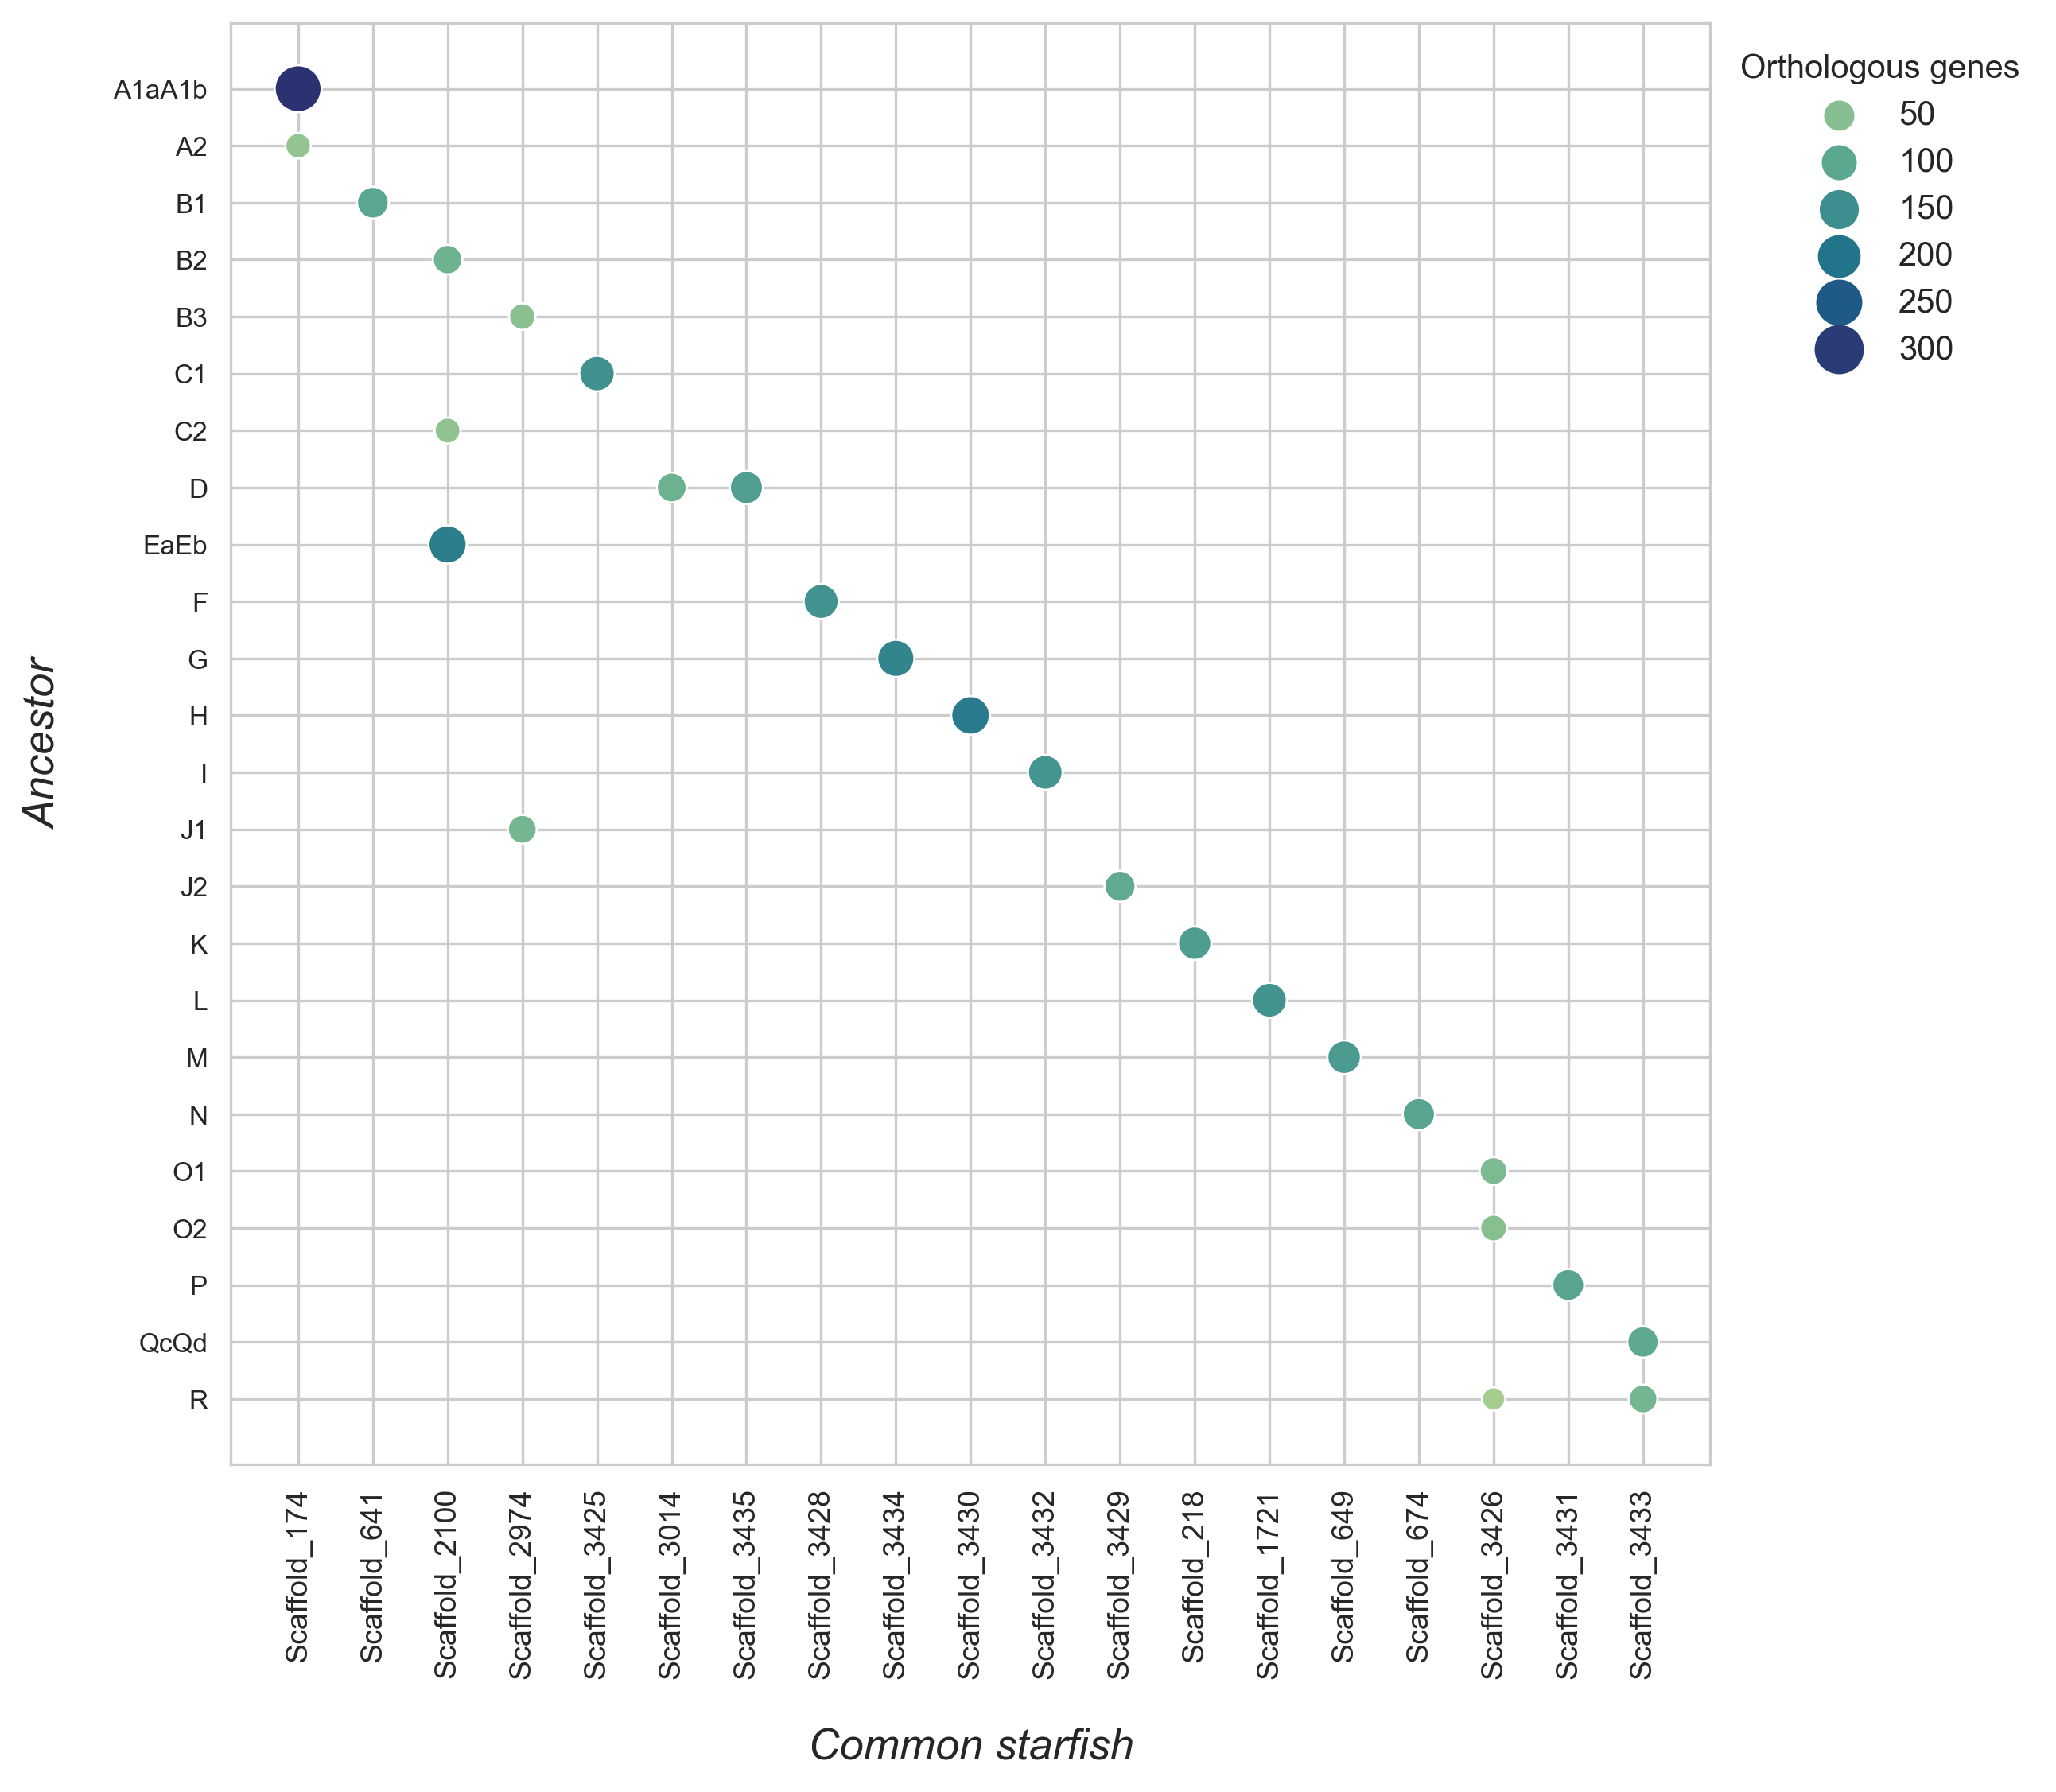

In [7]:
AB = Orthoscripts.orthofind(Ancestor, Parliv, Holleu_Parliv)
Orthoscripts.orthoplot(AB, 'Common starfish', 'Ancestor', 'B', 'A')

In [8]:
Orthoscripts.rearrangements(AB)

Fission of ancestral chromosome D into ['Scaffold_3014', 'Scaffold_3435']
Fission of ancestral chromosome R into ['Scaffold_3426', 'Scaffold_3433']
Fusion of ancestral chromosomes ['A1aA1b', 'A2'] into Scaffold_174
Fusion of ancestral chromosomes ['B2', 'C2', 'EaEb'] into Scaffold_2100
Fusion of ancestral chromosomes ['B3', 'J1'] into Scaffold_2974
Fusion of ancestral chromosomes ['O1', 'O2', 'R'] into Scaffold_3426
Fusion of ancestral chromosomes ['QcQd', 'R'] into Scaffold_3433


-----
### Simulations

In [2]:
# Modified function, only returns 
def orthofind(genelistA, genelistB, orthologies):
    
    """
    inputs:
    genelistA: gene list for species A
    genelistB: gene list for species B
    orthologies: orthology dataset
    
    outputs: dataframe with significant ortholog combinations 
             and their location in species A and B and p-Values
    """
    
    # Make ortholog dictionaries (ortholog : gene name)
    orthdictA = dict(zip(orthologies[:, 1], orthologies[:, 0]))
    orthdictB = dict(zip(orthologies[:, 2], orthologies[:, 0]))

    # Replace genelist values with ortholog dictionary keys
    A_data = genelistA.copy()
    B_data = genelistB.copy()
    A_data['Name'] = A_data['Name'].map(lambda x: orthdictA.get(x, x))
    B_data['Name'] = B_data['Name'].map(lambda x: orthdictB.get(x, x))
    
    # Make orthology location dictionaries (ortholog: chromosome)
    dictA = dict(zip(A_data.loc[A_data['Name'].str.contains('ortholog')].Name, 
                     A_data.loc[A_data['Name'].str.contains('ortholog')].Chromosome))
    dictB = dict(zip(B_data.loc[B_data['Name'].str.contains('ortholog')].Name, 
                     B_data.loc[B_data['Name'].str.contains('ortholog')].Chromosome))
    
    # Seperate all orthology entries into new dataframe
    AB_data = pd.DataFrame({'Orthologs': orthologies[:, 0],
                            'A' : orthologies[:, 0],
                            'B' : orthologies[:, 0]})
    
    # Replace location in A and B with ortholog location dictionary keys
    AB_data['A'] = AB_data['A'].map(dictA)
    AB_data['B'] = AB_data['B'].map(dictB)
    
    # Calculate number of orthologs for each pair of chromosomes
    AB_data = AB_data.groupby(['A', 'B']).count().reset_index()
    
    return AB_data

In [1]:
A = Orthoscripts.readBED("Simulations/sim_test/ancestor.geneslist.bed")
B = Orthoscripts.readBED("Simulations/sim_test/speciesA.geneslist.bed")
AB = np.loadtxt("Simulations/sim_test/ancestor+speciesA.txt", dtype = "str")

AB_data = orthofind(A, B, AB)
Orthoscripts.orthoplot(AB_data, 'Descendant', 'Ancestor', 'B', 'A')

NameError: name 'Orthoscripts' is not defined

In [27]:
def rearrangements(data):
    fusions = data.pivot(index = 'B', columns='A', values = 'Orthologs')
    fusions = fusions.loc[(fusions.where(fusions.isnull(), 1).sum(axis=1) > 1) | (fusions.sum(axis=0) > 1)]
    fusions = fusions.stack(dropna = True).reset_index().groupby('B')['A'].apply(list).reset_index(name = 'A')

    fissions = data.pivot(index = 'A', columns='B', values = 'Orthologs')
    fissions = fissions.loc[(fissions.where(fissions.isnull(), 1).sum(axis=1) > 1) | (fissions.sum(axis=0) > 1)]
    fissions = fissions.stack(dropna = True).reset_index().groupby('A')['B'].apply(list).reset_index(name = 'B')
    
    f = open("rearrangements.txt", "w+")
    for index, row in fissions.iterrows():
        print('Fission of', row['A'], 'into', row['B'])
        f.write('{0} {1} {2} {3}\n'.format('Fission of', row['A'], 'into', row['B']))
    for index, row in fusions.iterrows():
        print('Fusion of', row['A'], 'into', row['B'])
        f.write('{0} {1} {2} {3}\n'.format('Fusion of', row['A'], 'into', row['B']))
    f.close()